# MQTTSN - using `scapy` Package

MQTT and MQTT-SN are IP protocols used to manage devices in the Internet of Things.  These protocols implement a publish and subscribe communication protocol between *clients*.  The publish and subscribe communication is managed by *brokers*.  One of the key ideas of MQTT and MQTT-SN is that brokers are relatively robust and available, while clients are often transient (for instance they might often sleep to save power).  Typically a client will publish *events* to a broker.  Each event consists of a *topic* and a *message*. Typically the broker will relay each event to other clients who have subscribed to the same topic, although brokers may also communicate directly to relay events.  The main difference between MQTT and MQTT-SN is that MQTT is based on TCP, while MQTT-SN is based on UDP.  For more information, see http://mqtt.org/documentation.

Previously, we've shown how to use an off the shelf client (`paho`) to publish MQTT events.
Using the `scapy` package, we can also implement the protocol manually by constructing the correct packets.

## 1. Start MQTT broker

First we need to start a MQTT broker in order for all the clients to connect.

In [1]:
from broker_client.broker import Broker

broker_mqtt = Broker(mqtt_port=1883, mqttsn_port=1884)

When broker is open, users can connect to it; if there is already a broker
running, the following method will close it before opening a new one.

Users can also check the log file in `broker.log`.

In [2]:
broker_mqtt.open()

## 2. MQTTSN protocol with `scapy` package
In the following case we are sending packets to the local host.
Due to limitations of the loopback device, we need to force `scapy` to send raw packets.

In [3]:
from scapy.all import *
from broker_client.mqttsn_sw import *

conf.L3socket=L3RawSocket
serverIP = broker_mqtt.ip_address
serverPort = broker_mqtt.mqttsn_port

The first step in communicating with the broker is to establish a connection.
The response to this packet should be an `MQTTSN_CONNACK` packet.
Note that we don't have to populate all the parameters of the packet, 
as `scapy` is able to fill in some appropriate defaults.
It's possible that an ICMP error packet is returned if there is no broker 
operating at the given IP address.

The following cell establishes a connection.

In [4]:
try:
    sr1(IP(dst=serverIP)/UDP(sport=50000, dport=serverPort)/
        MQTTSN()/MQTTSN_CONNECT(client="test"))
except Exception as exc:
    print(str(exc))

Begin emission:
Finished to send 1 packets.

Received 18 packets, got 1 answers, remaining 0 packets


The next step is that we have to register a topic. In this case, the broker 
should remember that we opened a connection from this source port.
In this case, we add some error handling to check the result packet.
The expected response is an `MQTTSN_REGACK` packet, which contains a 
numeric topicID. MQTTSN often uses numeric topicIDs instead of strings to 
reduce the size of transmitted packets. Hence we need to store this topicID for later use.

The following cell registers a new topic. Note the returned topicID.

In [5]:
try:
    ack = sr1(IP(dst=serverIP)/UDP(sport=50000, dport=serverPort)/
              MQTTSN()/MQTTSN_REGISTER(topic="first_topic"))
except Exception as exc:
    print(str(exc))

if(isinstance(ack[IP].payload, ICMP)):
    print("Error response: ")
    ack[IP].payload.show()
else:
    if(not isinstance(ack[MQTTSN].payload, MQTTSN_REGACK)):
        print("Unknown response: ")
        ack[MQTTSN].payload.show()
    else:
        topicID = ack[MQTTSN_REGACK].topicID

print("First Topic ID = " + str(topicID))

Begin emission:
Finished to send 1 packets.

Received 22 packets, got 1 answers, remaining 0 packets
First Topic ID = 1


Now that we have a topic ID, we can publish and subscribe different messages.

The following cell publishes on the topic; `qos = 0` implies no response expected.

In [6]:
try:
    send(IP(dst=serverIP)/UDP(sport=50000,dport=serverPort)/
         MQTTSN()/MQTTSN_PUBLISH(topicID=topicID, message="foo"))
except Exception as exc:
    print(str(exc))


Sent 1 packets.


Now let's subscribe to a new topic (`second_topic`). Note the returned topicID 
(it should be a different ID).

In [7]:
try:
    ack = sr1(IP(dst=serverIP)/UDP(sport=50000,dport=serverPort)/
              MQTTSN()/MQTTSN_SUBSCRIBE(topic="second_topic", messageID=1))
except Exception as exc:
    print(str(exc))

if(isinstance(ack[IP].payload, ICMP)):
    print("Error response: ")
    ack[IP].payload.show()
else:
    if(not isinstance(ack[MQTTSN].payload, MQTTSN_SUBACK)):
        print("Unknown response: ")
        ack[MQTTSN].payload.show()
    else:
        topicID = ack[MQTTSN_SUBACK].topicID

print("Second Topic ID = " + str(topicID))

Begin emission:
Finished to send 1 packets.

Received 19 packets, got 1 answers, remaining 0 packets
Second Topic ID = 2


Publish on the original topic (`first_topic`) again. This time we get a `PUBLISH` response 
because we're subscribed.

In [8]:
try:
    sr1(IP(dst=serverIP)/UDP(sport=50000,dport=serverPort)/
        MQTTSN()/MQTTSN_PUBLISH(qos=0, topicID=topicID, message="foo"))
except Exception as exc:
    print(exc)

Begin emission:
Finished to send 1 packets.

Received 23 packets, got 1 answers, remaining 0 packets


Publish on `first_topic` again with `qos = 1` (guaranteed delivery).
This time we get a `PUBACK` acknowledgment.

In [9]:
try:
    sr1(IP(dst=serverIP)/UDP(sport=50000,dport=serverPort)/
        MQTTSN()/MQTTSN_PUBLISH(qos=1, topicID=topicID, message="foo"))
except Exception as exc:
    print(exc)

Begin emission:
Finished to send 1 packets.

Received 20 packets, got 1 answers, remaining 0 packets


## 3. Wrapping up MQTTSN
We can also wrap this up in a more abstract interface (like `paho.MQTT`).
The key difference here is that we're generating MQTTSN traffic, rather than 
MQTT.

The API is implemented in `mqttsn.py` for users to check.

In [10]:
with MQTT_Client(serverIP, serverPort, "client-test") as client:
    topicID = client.register("temp")
    if client.publish(topicID, "bar", qos=0):
        print("Publish Succeeded")
    else:
        print("Publish Failed")

Publish Succeeded


## 4. Continuously publishing events
The following cell keeps publishing events based on new values read from 
sensors. A Pmod TMP2 and a Pmod OLED are required to run the following cell.

On Pynq-Z1 board, please:
1. Connect Pmod OLED to the PMODA interface, and 
2. Connect Pmod TMP2 to the PMODB interface.

In [11]:
import timeit
import matplotlib.pyplot as plt
from pynq.overlays.base import BaseOverlay
from pynq.lib.pmod import Pmod_OLED
from pynq.lib.pmod import Pmod_TMP2

overlay = BaseOverlay("base.bit")
my_oled = Pmod_OLED(overlay.PMODA)
my_tmp = Pmod_TMP2(overlay.PMODB)

Now let's read the temperature sensor values and keep publishing them.

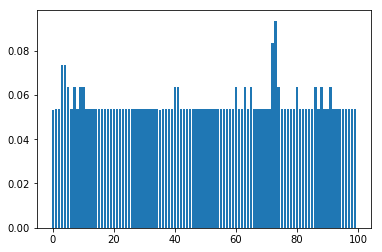

Average speed: 17.819144876510816 packets/second.


In [12]:
num_records = 100
time_records = [0 for _ in range(num_records)]
total_time = 0

with MQTT_Client(serverIP, serverPort, "client-temp") as client:
    temp_topicID = client.register("temp")
    for i in range(0, num_records):
        temperature = my_tmp.read()
        my_oled.clear()
        timestr = str(timeit.default_timer())
        tempstr = timestr[:9] + " " + str(temperature) + " C"
        my_oled.write(tempstr)
        
        start_time = timeit.default_timer()
        client.publish(temp_topicID, tempstr, qos=0)
        elapsed = timeit.default_timer() - start_time
        time_records[i] = elapsed
        total_time += elapsed

plt.bar(range(num_records), time_records, align='center')
plt.show()
print("Average speed: " + str(num_records/total_time)+" packets/second.")

Now let's change the `qos` value to check its impact on the performance. 
This is done by simply changing the following line:
```python
client.publish(temp_topicID, tempstr, qos=1)
```

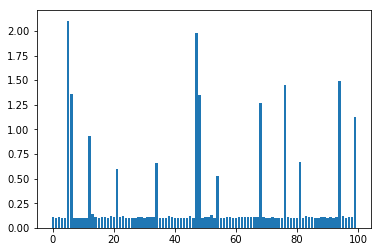

Average speed: 3.993580528090069 packets/second.


In [13]:
num_records = 100
time_records = [0 for _ in range(num_records)]
total_time = 0

with MQTT_Client(serverIP, serverPort, "client-temp") as client:
    temp_topicID = client.register("temp")
    for i in range(0, num_records):
        temperature = my_tmp.read()
        my_oled.clear()
        timestr = str(timeit.default_timer())
        tempstr = timestr[:9] + " " + str(temperature) + " C"
        my_oled.write(tempstr)
        
        start_time = timeit.default_timer()
        client.publish(temp_topicID, tempstr, qos=1)
        elapsed = timeit.default_timer() - start_time
        time_records[i] = elapsed
        total_time += elapsed

plt.bar(range(num_records), time_records, align='center')
plt.show()
print("Average speed: " + str(num_records/total_time)+" packets/second.")

## 5. Close the broker

It is always a good practice to close the broker after use. Otherwise it keeps
running in the background.

In [14]:
broker_mqtt.close()